In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image1 = cv2.imread('figs/test.jpg', 0)
image2 = cv2.imread('figs/Mulan2.jpg', 0)
image3 = cv2.imread('figs/Mulan3.jpg', 0)

# 1. Fourier Transform in Numpy

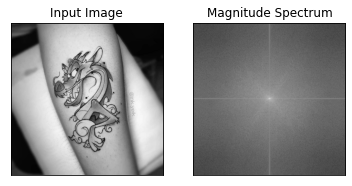

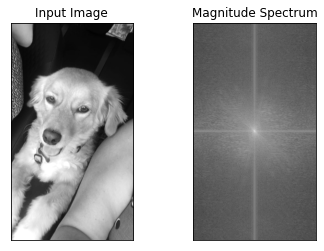

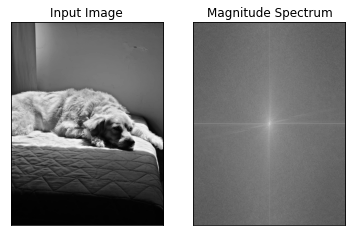

In [3]:
def numpy_fourier_magnitude(image):
    fourier = np.fft.fft2(image)
    fourier_shift = np.fft.fftshift(fourier)
    magnitude_spectrum = 20 * np.log(np.abs(fourier_shift))

    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Input Image')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(122)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Magnitude Spectrum')
    plt.xticks([])
    plt.yticks([])
    plt.show()

    return fourier_shift

image1_fourier_shift = numpy_fourier_magnitude(image1)
image2_fourier_shift = numpy_fourier_magnitude(image2)
image3_fourier_shift = numpy_fourier_magnitude(image3)

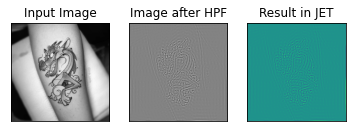

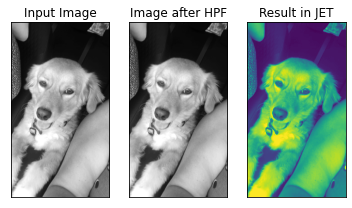

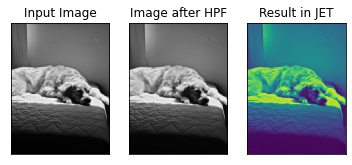

In [4]:
def numpy_fourier_back(image, fourier_shift):
    rows, cols = image.shape
    center_row, center_col = cols // 2, rows // 2
    fourier_shift[center_row - 30:center_row + 31, center_col - 30:center_col + 31] = 0
    fourier_inverse_shift = np.fft.ifftshift(fourier_shift)
    image_back = np.fft.ifft2(fourier_inverse_shift)
    image_back = np.real(image_back)

    plt.subplot(131)
    plt.imshow(image, cmap = 'gray')
    plt.title(f'Input Image')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(132)
    plt.imshow(image_back, cmap = 'gray')
    plt.title('Image after HPF')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(133)
    plt.imshow(image_back)
    plt.title('Result in JET')
    plt.xticks([])
    plt.yticks([])

    plt.show()

numpy_fourier_back(image1, image1_fourier_shift)
numpy_fourier_back(image2, image2_fourier_shift)
numpy_fourier_back(image3, image3_fourier_shift)


# 2. Fourier Transform in OpenCV

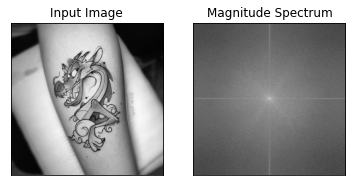

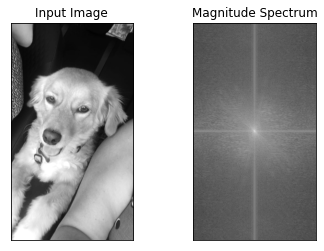

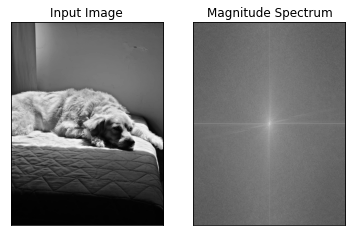

In [5]:
def opencv_fourier(image):
    dft = cv2.dft(np.float32(image),flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))
    plt.subplot(121)
    plt.imshow(image, cmap = 'gray')
    plt.title('Input Image')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(122)
    plt.imshow(magnitude_spectrum, cmap = 'gray')
    plt.title('Magnitude Spectrum')
    plt.xticks([])
    plt.yticks([])

    plt.show()

    return dft_shift

image1_dft_shift = opencv_fourier(image1)
image2_dft_shift = opencv_fourier(image2)
image3_dft_shift = opencv_fourier(image3)

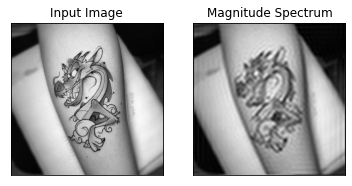

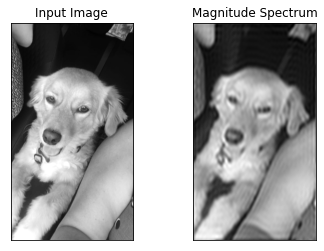

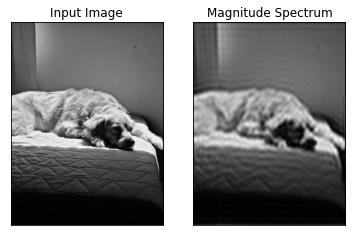

In [6]:
def opencv_fourier_back(image, dft_shift):
    rows, cols = image.shape
    center_row, center_col = rows // 2, cols // 2

    # create a mask first, center square is 1, remaining all zeros
    mask = np.zeros((rows, cols, 2), np.uint8)
    mask[center_row-30:center_row+30, center_col-30:center_col+30] = 1

    # apply mask and inverse DFT
    fshift = dft_shift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

    plt.subplot(121)
    plt.imshow(image, cmap = 'gray')
    plt.title('Input Image')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(122)
    plt.imshow(img_back, cmap = 'gray')
    plt.title('Magnitude Spectrum')
    plt.xticks([])
    plt.yticks([])

    plt.show()

opencv_fourier_back(image1, image1_dft_shift)
opencv_fourier_back(image2, image2_dft_shift)
opencv_fourier_back(image3, image3_dft_shift)

# 3. Performance optimization of DFT

### 3.1. Getting optimal image size

In [7]:
rows, cols = image1.shape
print(f'{rows} {cols}')

nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)
print(f'{nrows} {ncols}')

1080 1080
1080 1080


### 3.2. Creating an image with the optimal size

In [8]:
right = ncols - cols
bottom = nrows - rows
bordertype = cv2.BORDER_CONSTANT #just to avoid line breakup in PDF file
new_image = cv2.copyMakeBorder(image1, 0, bottom, 0, right, bordertype, value=0)

### 3.3. Comparing the times in Numpy

In [10]:
%timeit fft1 = np.fft.fft2(image1)
%timeit fft2 = np.fft.fft2(image1,[nrows,ncols])

29.7 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
28.1 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 3.4. Comparing the times in OpenCV

In [11]:
%timeit dft1= cv2.dft(np.float32(image1), flags=cv2.DFT_COMPLEX_OUTPUT)
%timeit dft2= cv2.dft(np.float32(new_image), flags=cv2.DFT_COMPLEX_OUTPUT)

7.38 ms ± 201 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.28 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# 4. Why Laplacian is a High Pass filter?

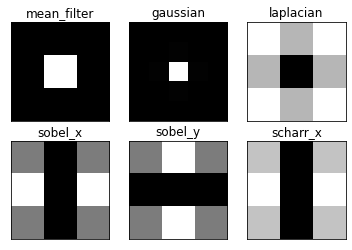

In [12]:
# simple averaging filter without scaling parameter
mean_filter = np.ones((3,3))

# creating a gaussian filter
x = cv2.getGaussianKernel(5,10)
gaussian = x * x.T

# different edge detecting filters
# scharr in x-direction
scharr = np.array([[-3, 0, 3],
                   [-10,0,10],
                   [-3, 0, 3]])
# sobel in x direction
sobel_x= np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# sobel in y direction
sobel_y= np.array([[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]])
# laplacian
laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian','laplacian', 'sobel_x', 'sobel_y', 'scharr_x']

fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(mag_spectrum[i],cmap = 'gray')
    plt.title(filter_name[i])
    plt.xticks([])
    plt.yticks([])

plt.show()